In [1]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import EarlyStopping

from keras.callbacks import ReduceLROnPlateau
import numpy as np
from sklearn.model_selection import train_test_split


Each image is presented as a reshaped 1D vector version of the image, next to the corresponding label in the "label" column.

Each image is labeled with a number, from 0 to 24 


Note:   
    
    (numbers 9 and 25 are skipped, corresponding to the letters "j" and "z", respectively)

In [2]:
# A simple mapping relating the label with its corresponding letter
mapping_dict = {}
value = 0
for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
    if letter in ["J", "Z"]:
        value += 1
        continue
    mapping_dict[letter] = value
    value += 1
inverted_dict = {v: k for k, v in mapping_dict.items()}

In [3]:
train_df = pd.read_csv("datasets/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("datasets/sign_mnist_test/sign_mnist_test.csv")

display("train_df: ", train_df.sample(5))

y_train = train_df[["label"]]
y_test = test_df[["label"]]
del train_df["label"]
del test_df["label"]

print("Labels: ", y_train.label.sort_values().unique())

'train_df: '

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
24827,5,105,117,137,145,150,155,158,160,161,...,115,205,190,197,197,197,196,196,194,193
27186,13,177,179,180,182,184,186,187,188,189,...,209,209,208,207,206,206,205,204,203,201
11457,22,76,19,43,65,72,77,85,97,109,...,181,183,185,187,187,189,191,192,192,192
27198,2,184,184,186,186,186,186,186,185,184,...,184,185,184,181,181,181,182,178,175,178
14258,8,146,151,156,160,163,165,169,172,175,...,128,117,90,144,206,209,208,207,205,204


Labels:  [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


From the rounding 35000 of samples in total, 20% correspond to the training set, which seems appropriate

In [4]:
num_test = y_test.shape[0]
num_train = y_train.shape[0]

num_tot = num_test + num_train
print(f"Total number of samples: {num_tot}")
print(f"percentage of test samples: {100*num_test/num_tot:.2f}%")

Total number of samples: 34627
percentage of test samples: 20.71%


Categories seem balanced for both training and test sets

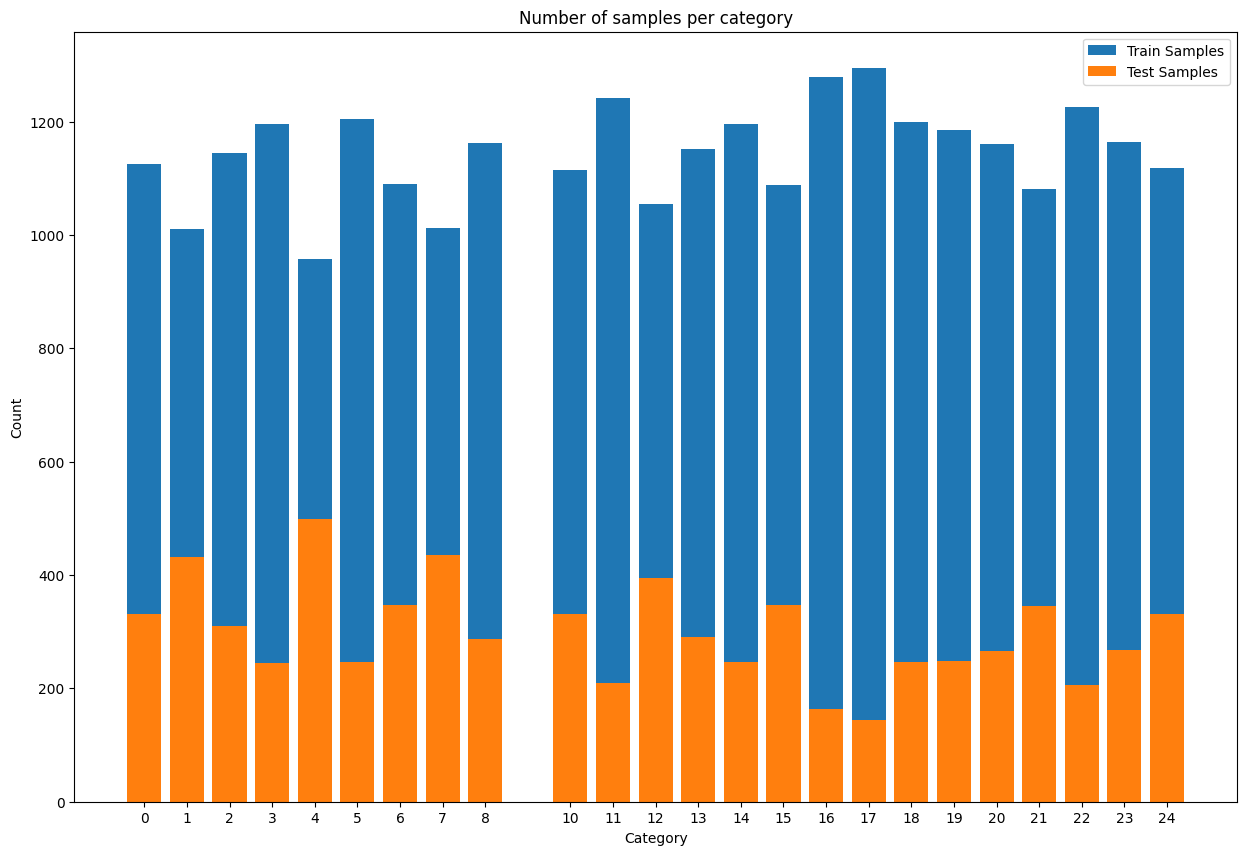

In [5]:
y_labels = y_train.label.unique()
bins = len(y_labels)

plt.figure(figsize=(15, 10))

train_label_counts = y_train.label.value_counts()
plt.bar(train_label_counts.index, train_label_counts.values, label="Train Samples")
test_label_counts = y_test.label.value_counts()
plt.bar(test_label_counts.index, test_label_counts.values, label="Test Samples")

plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Number of samples per category")
plt.xticks(sorted(y_labels))
plt.legend()

plt.show()

Data and set splitting seems great beforehand, however I will still not be confident on this pre-made train and test set sepparation, since no special consideration was specified on the dataset documentation over the reasons for the samples on the testing set to be those specific ones. With the aim to double check that the development and test sets are equally reppresentative  of the data, I will merge both sets and make my own splitting. (Both datsets were reviewed beforehand, and no apparent difference was identified between the samples)

In [6]:
full_df = pd.concat([train_df, test_df])
full_y = pd.concat([y_train, y_test])

# Preprocessing image data (each is a 28x28 pixel image)

x_full = full_df.values
# Normalize
x_full_norm = x_full / 255
# Reshape
num_pixels = int((full_df.shape[1]) ** (1 / 2))
x_full_norm = x_full_norm.reshape(-1, num_pixels, num_pixels, 1)

# Output as numpy array
y_full = full_y.values

Checking some of the images and its corresponding labels 

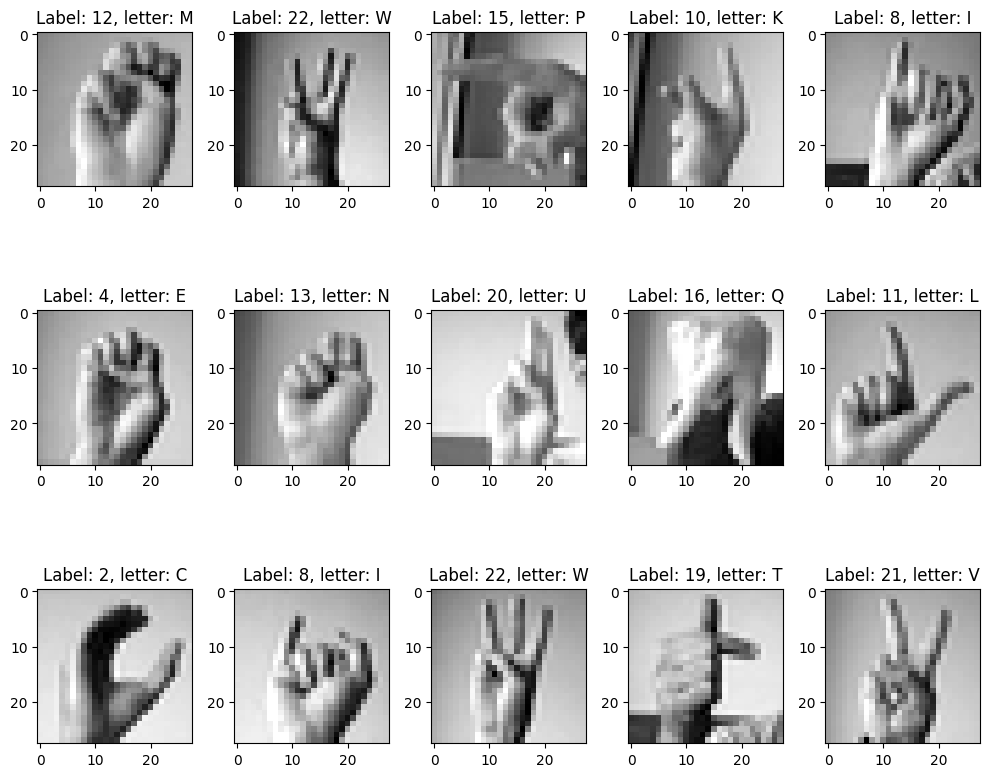

In [7]:
check_on = x_full_norm
label_on = y_full
n_rows = 3
n_cols = 5

f, ax = plt.subplots(n_rows, n_cols)
f.set_size_inches(10, 10)
for i in range(n_rows):
    for j in range(n_cols):
        im_idx = random.randint(0, check_on.shape[0])
        label = label_on[im_idx][0]
        ax[i, j].imshow(check_on[im_idx], cmap="gray")
        ax[i, j].set_title(f"Label: {label}, letter: {inverted_dict[label]}")
    plt.tight_layout()

In addition I will introduce another set for hold-out cross validation (developement set) to decide on diverse hyperparameters. 

The percentages defined for the splitting are:

Training set: 70%  for training

development set: 15%  To compare between different models and hyperparameters

Test set: 15%  To check final model's performance

In [8]:
# Splitting of the dataset
x_train, x_devtest, y_train, y_devtest = train_test_split(
    x_full_norm, y_full, train_size=0.7, shuffle=True
)
x_dev, x_test, y_dev, y_test = train_test_split(
    x_devtest, y_devtest, test_size=0.5, shuffle=True
)
total_len = x_full_norm.shape[0]
x_train_len = x_train.shape[0]
x_dev_len = x_dev.shape[0]
x_test_len = x_test.shape[0]
print(f"x_train percentage = {x_train_len/total_len:.02f}")
print(f"x_dev percentage = {x_dev_len/total_len:.02f}")
print(f"x_test percentage = {x_test_len/total_len:.02f}")

x_train percentage = 0.70
x_dev percentage = 0.15
x_test percentage = 0.15


Checking on data balance again visually.

dev and test set quantities overlaps since both represent equally 15% of the data

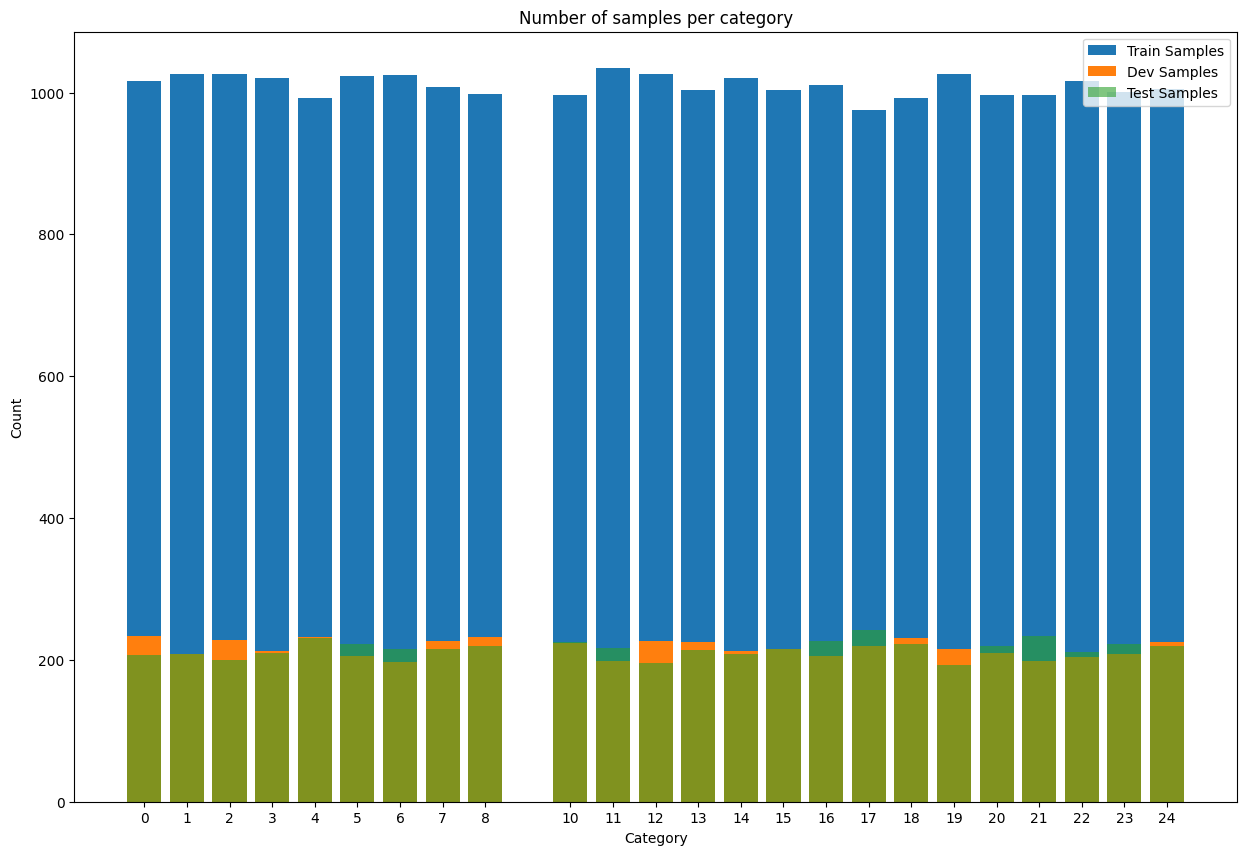

In [9]:
y_labels = np.unique(y_train)
bins = len(y_labels)

plt.figure(figsize=(15, 10))

train_label_counts = pd.DataFrame(y_train).value_counts()
plt.bar([idx[0] for idx in train_label_counts.index], train_label_counts.values, label="Train Samples")
dev_label_counts = pd.DataFrame(y_dev).value_counts()
plt.bar([idx[0] for idx in dev_label_counts.index], dev_label_counts.values, label="Dev Samples")
test_label_counts = pd.DataFrame(y_test).value_counts()
plt.bar([idx[0] for idx in test_label_counts.index], test_label_counts.values, label="Test Samples", alpha=0.6)


plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Number of samples per category")
plt.xticks(sorted(y_labels))
plt.legend()

plt.show()

Formatting the Output:

OneHotEncoder was selected over label encoding, since categories in this dataset has no ordinal nature, meaning that no letter weights or values more than other.

(maybe I should have done this before splitting the dataset to save some lines of code)

In [10]:
# OUTPUT ENCODING

oh_encoder = OneHotEncoder()

y_train_oh = oh_encoder.fit_transform(y_train).toarray()
y_dev_oh = oh_encoder.fit_transform(y_dev).toarray()
y_test_oh = oh_encoder.fit_transform(y_test).toarray()

Augmenting the data:


Slight rotation of 15%.

Width and height shift set to 10%

zoom range set to 10%

Brightness was set to range between 40% to 60% (brightness_range=0 means absolute darkness and brightness_range=1 maximum brightness)

The "fill_mode" parameter was chosen as "nearest" (fills with the nearest pixels), as there is not an important evident pattern to be learned in the images background.

A horizontal flip was included, since the same letters should be equally recognized when performed with the left or the right hand (inclusion means also considering people missing extremities)

Vertical flip is set to False, since upside down sign communication is not quite a common thing :) 


In [11]:
# Data Augmentation

img_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.4, 0.6),
    fill_mode="nearest",
    horizontal_flip=False,
    vertical_flip=False,
)

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

def convolutional_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    Z1 = tf.keras.layers.Conv2D(filters=8,kernel_size=4,strides=1,padding='same')(input_img)
    A1 = tf.keras.layers.ReLU()(Z1)
    P1 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2,padding='same')(A1)
    Z2 = tf.keras.layers.Conv2D(filters=16,kernel_size=2,strides=1,padding='same')(P1)
    A2 = tf.keras.layers.ReLU()(Z2)
    P2 = tf.keras.layers.MaxPool2D(pool_size=2,strides=2,padding='same')(A2)
    F = tf.keras.layers.Flatten()(P2)
    outputs = tf.keras.layers.Dense(units=24,activation='softmax')(F)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [20]:
conv_model = convolutional_model((28, 28, 1))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 8)         136       
                                                                 
 re_lu_4 (ReLU)              (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 16)        528       
                                                                 
 re_lu_5 (ReLU)              (None, 14, 14, 16)        0         
                                                           

In [22]:
history = conv_model.fit(x_train, y_train_oh, epochs=10, batch_size=10, callbacks=[reduce_lr,early_stopping])

Epoch 1/10
2424/2424 [==============================] - 8s 3ms/step - loss: 0.0015 - accuracy: 0.9997 - lr: 5.0000e-04
Epoch 2/10
2424/2424 [==============================] - 8s 3ms/step - loss: 0.0021 - accuracy: 0.9993 - lr: 5.0000e-04
Epoch 3/10
2414/2424 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.9993
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2424/2424 [==============================] - 8s 3ms/step - loss: 0.0030 - accuracy: 0.9993 - lr: 5.0000e-04
Epoch 4/10
2424/2424 [==============================] - 8s 3ms/step - loss: 3.3771e-04 - accuracy: 1.0000 - lr: 2.5000e-04
Epoch 5/10
2424/2424 [==============================] - 8s 3ms/step - loss: 2.0116e-04 - accuracy: 1.0000 - lr: 2.5000e-04
Epoch 6/10
2419/2424 [============================>.] - ETA: 0s - loss: 1.8168e-04 - accuracy: 1.0000
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
2424/2424 [==============================] - 8s 3ms/step

In [24]:
conv_model.evaluate(x_dev, y_dev_oh)

163/163 [==============================] - 1s 2ms/step - loss: 9.9524e-05 - accuracy: 1.0000


[9.952359687304124e-05, 1.0]